This notebook takes points from within the AEM survey area, samples the conductivity model and then interpolates point data onto the AEM layered model
Neil Symington
neil.symington@ga.gov.au

In [1]:
%matplotlib inline

In [2]:
from sqlite3 import dbapi2 as sqlite
from shapely.geometry import Polygon
import pandas as pd
import numpy as np
from hydrogeol_utils import spatial_functions, AEM_utils, plotting_utils, borehole_utils
from geophys_utils._netcdf_point_utils import NetCDFPointUtils
import matplotlib.pyplot as plt
import netCDF4
import os
import fiona
import sqlalchemy as db
from sqlalchemy import create_engine, event
import netCDF4
import yaml
import warnings
warnings.filterwarnings("ignore",category =RuntimeWarning)

C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
# First we will import the AEM conductivity point line data
# The AEM data is in a netCDF file created from a asci files using geophys_utils
# https://github.com/GeoscienceAustralia/geophys_utils


# Load East Kimberley data
infile  = r"\\prod.lan\active\proj\futurex\East_Kimberley\Data\Processed\Geophysics\AEM\EK_nbc_inversions\OrdKeep_borehole_constrained\netcdf\OrdKeep2019_ModeExp_cor2DLogOrd.nc"
ek_cond = netCDF4.Dataset(infile)

# Create an instance of point utils

cond_point_util = NetCDFPointUtils(ek_cond)

wkt, aem_coords = cond_point_util.utm_coords(cond_point_util.xycoords)

In [4]:
aem_coords

array([[ 430906.00000008, 8293543.99994572],
       [ 430916.40000008, 8293544.99994572],
       [ 430926.80000008, 8293545.99994572],
       ...,
       [ 472486.50000003, 8291890.99994567],
       [ 472474.20000003, 8291895.99994567],
       [ 472461.90000003, 8291899.99994567]])

In [5]:
infile = r"\\prod.lan\active\proj\futurex\East_Kimberley\Data\Processed\Physiography\Soil\Keep_soil_EC_compiled\EK_EC_compiled_completed.csv"
df_EC = pd.read_csv(infile)

df_EC    

,site_id,latitude,longitude,Easting,Northing,Depth_from,Depth_to,EC,units,EC_S/m,source,method
0,RN29517,-15.343860,129.150862,516192.6000,8303635.300,0.00,1.00,42.30000,uS/cm,0.000423,Humphrey's,soil
1,RN29517,-15.343860,129.150862,516192.6000,8303635.300,1.00,2.00,38.40000,uS/cm,0.000384,Humphreys,soil
2,RN29517,-15.343860,129.150862,516192.6000,8303635.300,2.00,3.00,355.00000,uS/cm,0.003550,Humphreys,soil
3,RN29517,-15.343860,129.150862,516192.6000,8303635.300,3.00,4.00,543.00000,uS/cm,0.005430,Humphreys,soil
4,RN29517,-15.343860,129.150862,516192.6000,8303635.300,4.00,5.00,835.00000,uS/cm,0.008350,Humphreys,soil
5,RN29517,-15.343860,129.150862,516192.6000,8303635.300,5.00,6.00,1069.00000,uS/cm,0.010690,Humphreys,soil
6,RN29517,-15.343860,129.150862,516192.6000,8303635.300,6.00,7.00,1501.00000,uS/cm,0.015010,Humphreys,soil
7,RN29517,-15.343860,129.150862,516192.6000,8303635.300,7.00,8.00,1900.00000,uS/cm,0.019000,Humphreys,soil
8,RN29517,-15.343860,129.150862,516192.6000,8303635.300,8.00,9.00,1502.00000,uS/cm,0.015020,Humphreys,soil
9,RN29517,-15.343860,129.150862,516192.6000,8303635.300,9.00,10.00,985.00000,uS/cm,0.009850,Humphreys,soil


In [6]:
df_EC_sites = df_EC.groupby(by='site_id', as_index=False).mean()[['site_id',
                                                                  'Easting', 'Northing']]

In [7]:
# Nearest neighbour search

distances, indices = spatial_functions.nearest_neighbours(df_EC_sites[['Easting', 'Northing']],
                                                         aem_coords, points_required = 10, 
                                                          max_distance = 250.)



In [8]:
# We will save the profiles in a pandas dataframe with a SNMR site key column

df_conductivity = pd.DataFrame(columns = {'site_id',
                                          'Depth_from',
                                          'Depth_to',
                                          'conductivity',
                                          'Easting', 'Northing'})

# Iteratively extract the conductivity profiles

for i, (index, row) in enumerate(df_EC_sites.iterrows()):
    
    
    
    # This is a check against null which are returned if the nearest neighbour is further
    # than the maximum distance
    if not np.isnan(distances[i]).all():
        
        df_conductivity_profile = AEM_utils.extract_conductivity_profile(ek_cond,
                                                       distances[i],
                                                       indices[i],
                                                       as_dataframe = True)
        # Add the SNMR id to the column
        df_conductivity_profile['site_id'] = row['site_id']
        
        df_conductivity_profile['Easting'] = row['Easting']
        
        df_conductivity_profile['Northing'] = row['Northing']
    
        # Append the site profile to the dataframe
        df_conductivity = df_conductivity.append(df_conductivity_profile, sort = True)
    
df_conductivity.reset_index(inplace=True, drop=True)

In [9]:
# Iterate through the sites, inteprolate the EC onto the AEM intervals and add them to the dataframe

for site in df_EC['site_id'].unique():
    
    mask = df_EC['site_id'] == site
    
    df_EC_site = df_EC[mask]
    
    mask  = df_conductivity['site_id'] == site
    
    df_cond_site = df_conductivity[mask]
    
    # Interpolate 
    
    df_interpolated = spatial_functions.interpolate_layered_model(df_EC_site, ['EC_S/m'],
                                                                  ['Depth_from', 'Depth_to'],
                                                                  df_cond_site[['Depth_from', 'Depth_to']])
    
    print(df_interpolated)
    print(df_EC_site)
    break


c:\users\u77932\documents\github\hydrogeol_utils\hydrogeol_utils\spatial_functions.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  new_intervals[p] = np.nan


     EC_S/m  Depth  thickness  weights
0  0.000423    0.0        0.5      0.5
2  0.000384    1.0        0.5      0.5
0    0.5
2    0.5
Name: thickness, dtype: float64
    EC_S/m  Depth  thickness   weights
5  0.00355    2.0   0.434783  0.434783
7  0.00543    3.0   0.434783  0.434783
9  0.00835    4.0   0.130435  0.130435
5    0.434783
7    0.434783
9    0.130435
Name: thickness, dtype: float64
     EC_S/m  Depth  thickness  weights
10  0.00835    4.3       0.28     0.28
12  0.01069    5.0       0.40     0.40
14  0.01069    6.0       0.32     0.32
10    0.28
12    0.40
14    0.32
Name: thickness, dtype: float64
      EC_S/m  Depth  thickness   weights
15  0.014146    6.8   0.068965  0.068965
17  0.019000    7.0   0.344828  0.344828
19  0.015020    8.0   0.344828  0.344828
21  0.009850    9.0   0.241379  0.241379
15    0.068965
17    0.344828
19    0.344828
21    0.241379
Name: thickness, dtype: float64
     EC_S/m  Depth  thickness  weights
22  0.00985    9.7    0.09375  0.09375
24  0.0

In [11]:
df_interpolated = df_interpolated[df_interpolated['EC_S/m'] != 0]

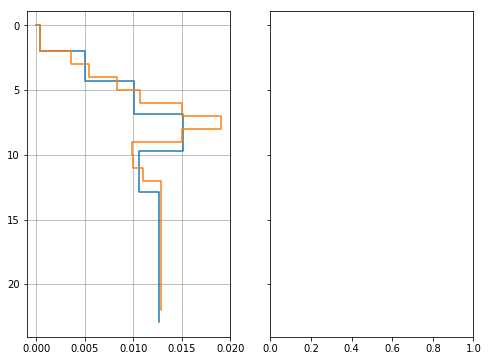

In [12]:
fig, (ax1,ax2) = plt.subplots(1,2, sharey = True, figsize = (8,6))

ax1 = plotting_utils.plot_1D_layered_model(ax1, df_interpolated['EC_S/m'].values,
                                  df_interpolated['Depth_from'].values,
                                           doi=None, log_plot=False)

ax2 = plotting_utils.plot_1D_layered_model(ax1, df_EC_site['EC_S/m'].values,
                                  df_EC_site['Depth_from'].values,
                                           doi=None, log_plot=False)


plt.gca().invert_yaxis()

plt.show()
